![ICL](Images/imperiallogo.jpeg)

# Introduction to Bayesian methods in ecology and evolution

## Thursday: 09 - Approximate Bayesian Computation

### Intended Learning Outcomes

At the end of this part you will be able to:
* appreciate the applicability of ABC,
* describe the rejection algorithm,
* critically discuss the choice of summary statistics,
* implement ABC methods.

The posterior probability
\begin{equation}
    P(\theta|x) = \frac{f(x|\theta)\pi(\theta)}{m(x)}
\end{equation}
can be difficult to compute as the marginal likelihood
\begin{equation}
    m(x) = \int f(x|\theta)\pi(\theta)d\theta
\end{equation}
may involve a high dimensional integral difficult (or impossible) to solve.

If the likelihood can be evaluated up to a normalising constant, Monte Carlo methods can be used to sample from the posterior.

As the models become more complicated, the likelihood function becomes difficult to define and compute.

Under these circumstances it is easier to __simulate__ data samples from the model given the value of a parameter.

If the data are discrete and of low dimensionality, then it is possible to sample from the posterior density of the parameter without an explicit likelihood function and without approximation.

### Rejection algorithm

If data points are __discrete__ and of low dimensionality, given observation $y$, the algorithms repeat the following until $N$ points have been accepted:
* Draw $\theta_i \sim \pi(\theta)$
* Simulate $x_i \sim f(x|\theta_i)$
* Reject $\theta_i$ if $x_i \neq y$

These are sampled from $P(\theta|x)$.

The posterior distribution gives the probability distribution of the parameter values that gave rise to the observations.
To calculate summaries of this distribution it is possible to draw a histogram and derive notable percentiles.

<img src="Images/Elephants.jpg" width="300" height="300" />
We observe $4$ herds arriving. The likelihood is Poisson-distributed with a Gamma-shaped prior $G(3,1)$.
The posterior distribution is Gamma distributed with shape parameter $3+4=7$ and scale $0.5$.

Here we assume that we don't know the likelihood function but we can simulate data under this unknown function.

In [3]:
# load some already prepared functions
source("Data/abc.R")

# Rejection algorithm
N <- 1e4

# data/observations
y <- 4

# function to simulate is called "simulateElephants"
thetas <- c()
while (length(thetas) <= N) {

        # 1. draw from prior (continuous, bounded, uniform)
        theta <- runif(1,0,20)

        # 2. simulate observations
        ysim <- simulateElephants(theta)

        # 3. accept/reject
        if (ysim == y) thetas <- c(thetas, theta)

}

2.5%       25%       50%       75%     97.5% 
 1.647380  3.358585  4.668643  6.258461 10.310254

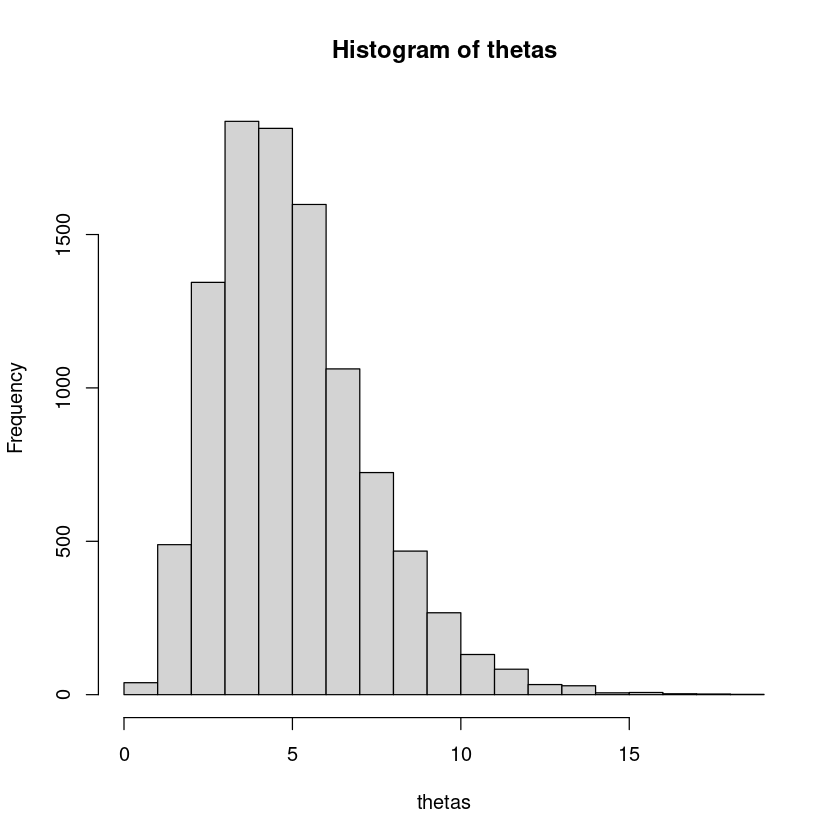

In [5]:
hist(thetas)
quantile(thetas, c(0.025,0.25,0.5,0.75,0.975))

If the data are __continuous__ and of low dimensionality, given observation $y$, the algorithms repeat the following until $N$ points have been accepted:
* Draw $\theta_i \sim \pi(\theta)$
* Simulate $x_i \sim f(x | \theta_i)$
* Reject $\theta_i$ if $\rho(x_i,y) > \epsilon$

where $\rho(\cdot)$ is a function measuring the distance between simulated and observed points.

$\rho(\cdot)$ can be the Euclidean distance $\rho(x_i, y) = \sqrt[]{(x_i-y)^2}$

<img src="Images/BumpassHell.jpeg" width="300" height="300" />
Prior distribution is $U(80,110)$.
Assume we don't know the likelihood function but we can simulate observations that are distributed according to it.
We have a single observation of the temperature $y=91.3514$.

In [6]:
source("Data/abc.R")
# Rejection algorithm in the continuous case
N <- 1e3
y <- 91.3514
epsilon <- 1e-1 

# function to simulate is called "simulateWaterTemp"

# euclidean distance
rho <- function(x,y) sqrt((x-y)^2)

thetas <- c()
while (length(thetas) <= N) {

        # 1. draw from prior (continuous, bounded, uniform)
        theta <- runif(1, min=80, max=110)

        # 2. simulate observations
        ysim <- simulateWaterTemp(theta)

        # 3. accept/reject
        if (rho(ysim,y)<=epsilon) thetas <- c(thetas, theta)

}


In [ ]:
print(mean(thetas))
print(var(thetas))
hist(thetas)
quantile(thetas, c(0.025,0.25,0.5,0.75,0.975))

You can appreciate that the more the prior is different from the unknown likelihood function, the lower the acceptance rate.

Instead of choosing $\epsilon$, we can rank all distances and select only a proportion of the lowest ones.

In this case one sets the number of simulations to be performed (not the number of accepted simulations) and the proportions of simulations to retain.

It is convenient to investigate the distribution of ranked distances to be sure to retain true outliers in the distribution.

__ACTIVITY__ 

Implement an ABC rejection algorithm to estimate $\theta$ assuming that
* observations are $Y=\{91.34, 89.21, 88.98\}$
* $\theta$ has prior as a Normal distribution centered around 90 with large variance and defined only in $80 \leq \theta \leq 110$
* the simulating function is called "simulateWaterTemp" in "Data/abc.R"
* the distance function is $\rho(x_i, Y)=\frac{\sum_{j \in Y} \sqrt[]{(x_i-j)^2}}{|Y|}$ where ${|Y|}$ is the cardinality, the number of elements in $Y$.
* the total number of simulations is $10,000$ and we want to accept the first $5\%$ sorted by increasing distance

Complete the following tasks:
* plot the sampled prior distribution
* plot the distribution of ranked distances with indication of $5\%$ threshold: assess whether the accepted values are likely to come from the (true and unknown) posterior distribution
* plot the posterior distribution
* calculate expected value and notable quantiles and HPD $95\%$ (using the library `coda` and function `HPDinterval(as.mcmc(x), prob=0.95)`)

In [ ]:
source("Data/abc.R")
# Rejection algorithm with proportions of simulations to accept
N <- 1e4
Y <- c(91.34, 89.21, 88.98)
th <- 0.05

# function to simulate is called "simulateWaterTemp"
source("Data/abc.R")
thetas <- c()
if (i <- N){
    theta <- rnorm(1, mean = 90, lower =80, higher=110)
}

# distance function
# ...

# ...

When the data become high dimensional (e.g. multivariate measurements) then it is necessary to reduce the dimensionality via the use of summary statistics.

For instance, the complete genome of many samples has high dimensionality as it may have up to $N*L$ genotypes with $N$ samples and $L$ number of sites per-genome.

One can calculate summary statistics $S(y)$ to describe some features of the data (e.g. indexes of genetic diversity in the case of multiple genomes).

If data points are of __high dimensionality__, given observation $y$, repeat the following until $N$ points have been accepted:
* Draw $\theta_i \sim \pi(\theta)$
* Simulate $x_i \sim f( x | \theta_i)$
* Reject $\theta_i$ if $\rho(S(x_i),S(y))>\epsilon$

where $S(y)$ is a summary statistic.

The function $S(\cdot)$ can be a vector.

The use of summary statistics is a mapping from a high dimension to a low dimension.
Some information is lost, but with enough summary statistics much of the information is kept.

The aim for the summary statistics is to satisfy Bayes' sufficiency
\begin{equation}    P(\theta|x)=P(\theta|S(x))
\end{equation}

The first example of an ABC approach was introduce by Pritchard et al. (1999).
They summarised information for 445 Y-chromosome genes copies at eight microsatellites (and therefore 445 times 8 dimensions) into three numbers.
The distance was chosen to be a normalised Chebyshev distance
\begin{equation}
    \max_j | \frac{S_j(x)}{S_j(y)} - 1|
\end{equation}
for $j=1,...,s$ summary statistics.

One of the issues in ABC is _the curse of the dimensionality_ when using more than a few summary statistics.
If summary statistics are uncorrelated, using the above distance, we will reject many simulations with increasing number of summary statistics.

Solutions have been proposed in order to
1. use a wider acceptance tolerance
2. perform a better sampling from the prior.

### Regression-based estimation

Local linear regression is used to derive the posterior distribution using ABC, to obtain a potentially wider set of accepted points.

<img src="Images/ABC.png" width="500" height="500" />

The algorithm is the following:
* Given observation $y$ repeat the following until $M$ points have been generated:
  * Draw $\theta_i \sim \pi(\theta)$
  * Simulate $x_i \sim f(x|\theta_i)$
* Calculate $S_j(x)$ for all $j$ and $k_j$, the empirical standard deviation of $S_j(x)$
* $\rho(S(x),S(y)):\sqrt[]{\sum_{j=1}^s ( \frac{S_j(x)}{k_j} - \frac{S_j(y)}{k_j} )^2 }$
* Choose tolerance $\epsilon$ such that the proportion of accepted points $P_\epsilon=\frac{N}{M}$
* Weight the simulated points $S(x_i)$ using $K_\epsilon(\rho(S(x_i),S(y)))$ where
\begin{align}
    K_\epsilon(t) &= \epsilon^{-1}(1-(t/\epsilon)^2) & \text{for } t \leq \epsilon \\
    K_\epsilon(t) &= 0 & \text{for } t > \epsilon
\end{align}
* Apply weighted linear regression to the $N$ points that have nonzero weight to obtain an estimate of $\hat{E}(\theta|S(x))$
* Adjust $\theta_i^*=\theta_i-\hat{E}(\theta|S(x))+\hat{E}(\theta|S(y))$
* The $\theta_i^*$ with weights $K_\epsilon(\rho(S(x_i),S(y)))$ are random draws from an approximation of the posterior distribution $P(\theta|y)$.

There are problems with regression-based methods too.
When the observed summary statistics lies outside the unknown likelihood distribution (model misspecification), then regression is an extrapolation rather than an interpolation.
In these cases posterior draws (after regression adjustments) can be outside the prior range.
This problem occurs when the observations lie at the boundaries of the unknown likelihood (called prior-predictive distribution in the ABC context).

To increase the performance of ABC estimation we can do a better sampling.
Indeed, the great majority of simulated parameter values may not give rise to summary statistics that are similar enough to the observed data.
Efficiency will be slow as many points will be rejected or given negligible weight.
We therefore want a procedure whereby parameters are sampled from a distribution that is closer to the posterior than from the prior.
There are two main ways to do this, one via Markov Chain Monte Carlo (MCMC) and Sequential Monte Carlo (SMC) sampling.

### MCMC-ABC

Initialise by sampling $\theta^{(0)} \sim \pi(\theta)$. At iteration $t \geq 1$:
* Simulate $\theta' \sim K(\theta|\theta^{(t-1)})$ where $K(\cdot)$ is a proposal distribution that depends on the current value of $\theta$
* Simulate $x \sim p(x|\theta')$.
* If $\rho(S(x),S(y))<\epsilon$ (rejection step),
    * $u \sim U(0,1),$
    * if $u \leq \pi(\theta')/\pi(\theta^{(t-1)}) \times K(\theta^{(t-1)}|\theta')/K(\theta'|\theta^{(t-1)})$, update $\theta{(t)}=\theta'$, otherwise $\theta{(t)}=\theta^{(t-1)}$;
* otherwise $\theta{(t)}=\theta^{(t-1)}$.

A good proposal distribution should resemble the actual posterior distribution of the parameters.
A Normal proposal distribution often works well in practice, centred in $\theta^{(t-1)}$.
This is also called the _jumping_ distribution.
In this algorithm, at convergence the average distribution of proposed $\theta'$ is dominated by the posterior itself.

It is also possible to apply any regression-adjustment methods on the MCMC sample to obtain more accurate estimates.
Compared to the classic MCMC with likelihoods, this algorithm has higher rejection rate.
To circumvent this problem, the tolerance $\epsilon$ can be initially high and then reduced during the burn-in phase.

It was later proposed a method called Sequential Monte Carlo (SMC) for iteratively improving on an ABC approximation.
This approach consisted of two main features: (i) weighted resampling from the set of points already drawn and (ii) successive reduction in the tolerance $\epsilon$.

#### Model choice

Given a series of model $\mu_1, \mu_2, ..., \mu_N$ with prior probabilities $\sum_i \pi(\mu_i)=1$, we can calculate Bayes factors between two models $i$ and $j$ as
\begin{equation}
    \frac{p(\mu_i|x)}{p(\mu_j|x)} \div \frac{p(\mu_i)}{p(\mu_j)}  
\end{equation}

Typically, Bayes factors can be computed only if the parameters within the models have priors that integrate to one.
Therefore, Bayesian model choice can be strongly affected by the prior.
Notably, Bayesian model choice automatically penalised models with many parameters.
As such, one does not need to account for different number of parameters between models.

#### Hierarchical model

ABC can also be adopted in a hierarchical Bayesian model.
A potential difficulty here is that summary statistics should capture information from each unit so that the hyperparameters can be well inferred.
However, if there are many summary statistics it is unlikely that simulated data will closely match the observations.

#### Choice of summary statistics

<img src="Images/LucyBlanket.jpg" width="400" height="400" />

A very much arbitrary area of ABC modelling lies in the choice of summary statistics.
In some fields, there is a history of relating summary statistics to model parameters.
In general, there is no need of a strong theory relating summary statistics to model parameters.
One issue here is the effect of summary statistics on inferences and whether some choices may bias the outcome of model choice.
This may happen if chosen summary statistics have little relation to parameters in other models.
Typically, some summary statistics may cover some aspects of the model while other statistics may cover different aspects, making the choice of a finite set of informative units problematic.

The main idea is that as more summary statistics are used, then they should be jointly sufficient for the likelihood.
Also, summary statistics may be correlated to each other and to the parameters.
However, the accuracy and stability of ABC decreases rapidly with increasing numbers of summary statistics.

How can we choose the optimal set of summary statistics?

* One could calculate the ratio of posterior density with or without a particular summary statistic. Departures greater than a threshold are suggestive that the excluded summary statistic is important.
* Different summary statistics can be weighted differently according to their correlation with some model parameters.
* The number of summary statistics can also be reduced via multivariate dimensional scaling summary statistics should be scaled in order to have equal mean and variance, if normally distributed.
* Even if there is no need of a strong theory relating summary statistics to model parameters, it is suitable to have some expectations.

#### Model validation

Validation is the assessment of goodness-of-fit of the model to distinguish errors due to the approximation from errors caused by the choice of the model.

1. The distributions of simulated summary statistics are visualised and compared to the corresponding target statistic. If the target is outside, then this could be a problem in the model.
2. The observations are compared with the posterior predictive distribution. This can be done by simulating data with parameters drawn randomly from the current posterior distribution.

### Applications of ABC in evolution

The initial applications of ABC have been mainly in population genetics, using a rejection or regression algorithm.
Later on, a number of other areas in ecology, epidemiology and systems biology have seen an increase in the use ABC.
The more recent applications use MCMC or SMC algorithms.

In population genetics, the data consists of frequencies of alleles or haplotypes in one or more populations.
The goal is usually to estimate the demographic history of populations in terms of changes of population sizes, divergence times, migration rates, and so on.
A number of studies on inferring human evolution have been using ABC methods.

Patin et al. (2009) compared different demographic models that explain the genetic differentiation within different African populations.
<img src="Images/Patin1.png" width="400" height="400" />

<img src="Images/Patin2.png" width="600" height="600" />

### Applications of ABC in ecology

Some features of ecology, epidemiology and systems biology appear to be very similar.
Many aspects are captured by systems of partial or ordinary differential equations or stochastic differential equations.
Data often consist of time series and/or spatial data.
The goal here is to compare between hypothesised models that could explain the observed patterns and to infer parameters.

Toni et al. (2009) provide an example using a Lotka-Volterra system on prey-predator dynamics from time series data on abundances.
<img src="Images/Toni.png" width="600" height="600" />

ABC has also been used for agent-based models, protein interaction networks, speciation rates under a neutral ecological model, extinction rates from phylogenetic data, epidemiology (e.g. transmission).

* When a likelihood function is known and can be efficiently evaluated, then there is not advantage to use ABC.
* When the likelihood function is known but difficult to evaluate in practise, the ABC is a valid option.
* Many scenarios in evolutionary biology or ecology can be generated by simulations.
* ABC can be useful for initial exploratory phase.

### Intended Learning Outcomes

At the end of this part you are now be able to:
* appreciate the applicability of ABC,
* describe the rejection algorithm,
* critically discuss the choice of summary statistics,
* implement ABC methods.